In [1]:
import tempfile
import time
import networkx as nx
import numpy as np

from braket.aws import AwsQuantumJob, AwsSession

from braket.jobs.config import (
    DataSource,
    InputDataConfig,
    InstanceConfig,
    OutputDataConfig,
    S3DataSource,
    StoppingCondition
)
from braket.jobs.image_uris import Framework, retrieve_image

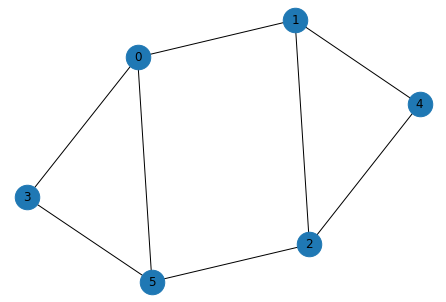

In [2]:
# We generate a random graph with num_nodes nodes and num_edges edges to run Max Cut on.
# num_nodes is the number of qubits, so each circuit will have runtime exponential in num_nodes
num_nodes = 6
num_edges = 8
seed = 1967
    
graph = nx.gnm_random_graph(num_nodes, num_edges, seed=seed)

# Draw the graph
positions = nx.spring_layout(graph, seed=seed)
nx.draw(graph, with_labels=True, pos=positions, node_size=600)

In [3]:
# Pick 'autograd', 'tf', or 'torch'. Autograd is base PennyLane
interface = "autograd"
# Specify device that the job will primarily be targeting
device_arn = "arn:aws:braket:::device/quantum-simulator/amazon/sv1"
# Specify previous job arn to copy checkpoints from, or None to not copy checkpoints
copy_checkpoints_from_job = None
# copy_checkpoints_from_job = "arn:aws:braket:<region>:<your-account-id>:job/<job-name>"

hyperparameters = {
    # Number of tasks per iteration = 2 * (num_nodes + num_edges) * p + 1
    "p": "2",
    "seed": str(seed),
    # Maximum number of simultaneous tasks allowed
    "max_parallel": "10",
    # Number of total optimization iterations, including those from previous checkpoint (if any)
    "num_iterations": "5",
    # Step size / learning rate for gradient descent
    "stepsize": "0.1",
    # Shots for each circuit execution
    "shots": "1000",
    "interface": interface,
}
if copy_checkpoints_from_job:
    hyperparameters['copy_checkpoints_from_job'] = copy_checkpoints_from_job

In [4]:
# Job data will be sent to this bucket by default,
# unless output_data_config is specified in the next cell.
aws_session = AwsSession()
bucket = aws_session.default_bucket()
print(bucket)

In [5]:
# Other possible settings
# Uncomment or edit to vary
kwargs = {
#     "stopping_condition": StoppingCondition(maxRuntimeInSeconds=5 * 24 * 60 * 60),
#     "output_data_config": OutputDataConfig(s3Path="s3://amazon-braket-your-bucket-name/your-folder-name"),
#     "instance_config": InstanceConfig(instanceType="ml.m5.large"),
}

In [6]:
# Function to upload the graph to S3 in an adjacency list format
def setup_input_stream():
    with tempfile.NamedTemporaryFile() as temp_graph_file:
        # define the uri for our input data stream
        stream_s3_uri = aws_session.construct_s3_uri(
            aws_session.default_bucket(),
            "input-graph",
        )
        # Write graph to a temporary file
        nx.write_adjlist(graph, temp_graph_file.name)
        # Upload temporary file to S3
        aws_session.upload_to_s3(temp_graph_file.name, f"{stream_s3_uri}/input-data.adjlist")
    return stream_s3_uri

In [7]:
region = aws_session.region

# Choose the container based on which one we need.
if interface == 'autograd':
    # Base container does not have PennyLane, so we have to use the TF or PyTorch container
    image_uri = retrieve_image(Framework.PL_TENSORFLOW, region)
elif interface == 'tf':
    image_uri = retrieve_image(Framework.PL_TENSORFLOW, region)
elif interface == 'torch':
    image_uri = retrieve_image(Framework.PL_PYTORCH, region)

In [8]:
start_time = time.time()

job = AwsQuantumJob.create(
    # Any unique name works. Note 50-character limit in job name
    job_name="JobTest-"+interface+"-"+str(int(time.time())),
    image_uri=image_uri,
    # Relative to the current location
    entry_point="source_dir.qaoa_algorithm_script:start_here",
    device_arn=device_arn,
    source_module="source_dir",
    copy_checkpoints_from_job=copy_checkpoints_from_job,
    # general parameters
    hyperparameters=hyperparameters,
    input_data_config=[InputDataConfig(
        channelName="input-graph",
        dataSource=DataSource(
            s3DataSource=S3DataSource(
                s3Uri=setup_input_stream(),
            ),
        ),
    )],
    # Uncomment the following to make this create() call wait for job completion
    # If so, the CloudWatch logs will be printed to the console as well
    # wait_until_complete=True,
    **kwargs
)

print(job.arn)
# Poll the job state asynchronously;
# not necessary if wait_until_complete was set to True
while job.state() not in AwsQuantumJob.TERMINAL_STATES:
    print(job.state())
    time.sleep(10)

end_time = time.time()
print(job.state())

arn:aws:braket:<region>:<account-id>:job/<job-name>
INITIALIZED
QUEUED
RUNNING
RUNNING
RUNNING
RUNNING
RUNNING
RUNNING
RUNNING
RUNNING
RUNNING
RUNNING
RUNNING
RUNNING
RUNNING
RUNNING
RUNNING
RUNNING
RUNNING
RUNNING
RUNNING
RUNNING
RUNNING
RUNNING
RUNNING
RUNNING
RUNNING
RUNNING
RUNNING
RUNNING
RUNNING
RUNNING
RUNNING
RUNNING
RUNNING
RUNNING
RUNNING
RUNNING
RUNNING
RUNNING
COMPLETED


In [9]:
print(end_time - start_time)

424.47294330596924


In [10]:
print(job.metadata())

In [11]:
print(job.result())

{'params': [[0.3823011957637408, 0.27088120680522054], [-0.17025138802088258, -0.1821198990587167]], 'cost': -5.29}


In [12]:
# May need to wait a bit before metrics show up
# If metrics aren't there, run a bit later
time.sleep(120)
print(job.metrics())

{'timestamp': [1631768935.6386075, 1631768931.8938987, 1631768917.6805806, 1631768896.5502882, 1631768873.4655097, 1631768855.3263783], 'Cost': [-5.29, -5.342, -4.973, -4.114, -4.015, -3.92], 'iteration_number': [5.0, 4.0, 3.0, 2.0, 1.0, 0.0]}


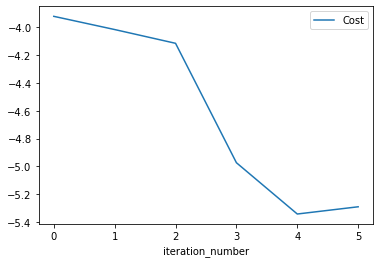

In [13]:
# A demonstration of plotting the metrics

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import pandas as pd

df = pd.DataFrame(job.metrics())

ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
figure = df.plot(x='iteration_number', y='Cost', ax=ax)

In [14]:
# Run this cell to print logs from CloudWatch
job.logs()

In [15]:
# Downloads results to current directory
job.download_result()